<a href="https://colab.research.google.com/github/EricCallaway/COSC_6319_Project/blob/NavyaMakkena_COSC_6319_Project/biLSTM_reviews_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

data=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Reviews.csv",nrows=100000)
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [3]:
!pip install contractions

     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 287 kB 39.9 MB/s 


In [4]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import contractions
import numpy as np
from nltk.stem import WordNetLemmatizer

def text_lowercase(text):
    return text.lower()

def remove_numbers(text):
    output_text = re.sub(r'\d+', '', text)
    return output_text

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_whitespace(text):
    return  text.strip()

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = " ".join([word for word in str(text).split() if word not in stop_words])
    return filtered_text

def remove_html(dataText):
    return BeautifulSoup(dataText, "lxml").text

def contraction_mapping(text):
    expanded_words = []   
    for word in text.split():
    # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))  
    expanded_text = ' '.join(expanded_words)
    return expanded_text

def lemmatization(text):
   lemmatizer = WordNetLemmatizer()
   return " ".join([lemmatizer.lemmatize(word) for word in text.split()])



def cleaning_data(content):
    # Lowercase text
    content = text_lowercase(content)

    # Remove numbers
    content = remove_numbers(content)

    # remove punctuation
    content = remove_punctuation(content)

    # remove whitespace from text
    content = remove_whitespace(content)

    # remove html from string
    content = remove_html(content)

    # contraction mapping
    content = contraction_mapping(content)

    # remove stopwords
    content = remove_stopwords(content)

    # lemmatization
    content = lemmatization(content)
    return content

print(data['Text'][0])
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(cleaning_data(t))

print(cleaned_text[:5])

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(cleaning_data(t))

print(cleaned_summary[:10])

data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
['bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanutsthe peanut actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around century light pillowy citrus gelatin nut case filbert cut tiny square liberally coated p

In [5]:
cnt=0
for i in range(len(cleaned_text)):
    if(len(cleaned_text[i].split())<=35):
        cnt=cnt+1
print(cnt/len(cleaned_text))

0.6115289354338901


In [6]:
max_text_len=35
max_summary_len=10

In [7]:
cleaned_text =np.array(cleaned_text)
cleaned_summary=np.array(cleaned_summary)

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
from sklearn.model_selection import train_test_split
reviews_tr,reviews_val,summary_tr,summary_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [8]:
from keras.preprocessing.text import Tokenizer
VOCAB_SIZE = 50000
article_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
# articles
article_tokenizer.fit_on_texts(list(reviews_tr))
article_sequences = article_tokenizer.texts_to_sequences(reviews_tr)
article_val_seq   =   article_tokenizer.texts_to_sequences(reviews_val)
art_word_index = article_tokenizer.word_index
print(len(art_word_index))
# summaries
summary_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
summary_tokenizer.fit_on_texts(list(summary_tr))
summary_sequences = summary_tokenizer.texts_to_sequences(summary_tr)
summary_val_seq   = summary_tokenizer.texts_to_sequences(summary_val) 
summary_word_index = summary_tokenizer.word_index
print(len(summary_word_index))

from keras.preprocessing.sequence import pad_sequences
import numpy as np

reviews_tr = pad_sequences(article_sequences, maxlen=max_text_len, padding='post', truncating='post')
summary_tr = pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post', truncating='post')
reviews_val = pad_sequences(article_val_seq, maxlen=max_text_len, padding='post', truncating='post')
summary_val = pad_sequences(summary_val_seq, maxlen=max_summary_len, padding='post', truncating='post')

print(reviews_tr.shape)
print(summary_tr.shape)

35041
9963
(48618, 35)
(48618, 10)


In [8]:
import numpy as np

embeddings_index = {}
with open('/content/drive/My Drive/Colab Notebooks/glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix for articles
article_embedding_matrix = np.zeros(((len(art_word_index)+1), embedding_dim))
for word, i in art_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        article_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(article_embedding_matrix.shape)

# Prepare embedding matrix for summaries
hits=0
misses = 0
summary_embedding_matrix = np.zeros((len(summary_word_index) + 1, embedding_dim))
for word, j in summary_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        summary_embedding_matrix[j] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(summary_embedding_matrix.shape)

Found 400001 word vectors.
Converted 18041 words (17000 misses)
(35042, 200)
Converted 7188 words (2775 misses)
(9964, 200)


In [9]:
from keras.layers import Embedding
import keras.initializers

encoder_embedding_layer = Embedding(
    input_dim = article_embedding_matrix.shape[0], #num_distinct_words
    output_dim = embedding_dim, #embedding_output_dims
    input_length = max_text_len, #max_sequence_length
    embeddings_initializer= keras.initializers.Constant(article_embedding_matrix),
    trainable = True
)

decoder_embedding_layer = Embedding(
    input_dim = summary_embedding_matrix.shape[0],
    output_dim = embedding_dim,
    input_length = max_summary_len,
    embeddings_initializer= keras.initializers.Constant(summary_embedding_matrix),
    trainable = True
)

In [10]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout,Input,Activation,Bidirectional,TimeDistributed

# Input layer
encoder_input = layers.Input(shape=(max_text_len))
encoder_embedded = encoder_embedding_layer(encoder_input)

# Decoder -- LSTM
decoder_input = layers.Input(shape=(None,))
decoder_embedded = decoder_embedding_layer(decoder_input)

# Encoder 1 -- Bidirectional LSTM 1
encoder1_output, forward_h1, forward_c1 ,backward_h1, backward_c1= Bidirectional(layers.LSTM(256, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4,name="encoder1"),merge_mode="concat")(
    encoder_embedded
)
# Encoder 2 -- Bidirectional LSTM 2
encode2_output, forward_h2, forward_c2 ,backward_h2, backward_c2= Bidirectional(layers.LSTM(256, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4,name="encoder2"),merge_mode="concat")(
    encoder1_output,initial_state=[forward_h1,backward_h1,forward_c1,backward_c1]
)
state_h2 =  layers.Concatenate()([forward_h2, backward_h2])
state_c2 =  layers.Concatenate()([forward_c2, backward_c2])
encoder2_state = [state_h2,state_c2]

# Pass the encoder 2 state to decoder LSTM layer, as initial state
decoder_LSTM= layers.LSTM(512,return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2,name="decoder")
decoder_output,decoder_state_h1 ,decoder_state_c1 = decoder_LSTM(
    decoder_embedded, initial_state=encoder2_state
)
# Dense layer with activation
decoder_dense = TimeDistributed(layers.Dense(len(summary_word_index)+1,activation='softmax'))
decoder_output = decoder_dense(decoder_output)

model = keras.Model([encoder_input, decoder_input], decoder_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 200)      7008400     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 35, 512),    935936      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                                 

In [11]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [12]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [13]:
history=model.fit([reviews_tr,summary_tr[:,:-1]], summary_tr.reshape(summary_tr.shape[0],summary_tr.shape[1], 1)[:,1:] ,
                  epochs=50,
                  callbacks=[es],
                  batch_size=128, 
                  validation_data=([reviews_val,summary_val[:,:-1]], summary_val.reshape(summary_val.shape[0],summary_val.shape[1], 1)[:,1:]))
model.save("/content/drive/My Drive/Colab Notebooks/saved_models/biLSTM_reviews_model")

Epoch 1/50
380/380 [==============================] - 394s 1s/step - loss: 2.1079 - sparse_categorical_accuracy: 0.7195 - val_loss: 1.8026 - val_sparse_categorical_accuracy: 0.7423
Epoch 2/50
380/380 [==============================] - 404s 1s/step - loss: 1.8451 - sparse_categorical_accuracy: 0.7380 - val_loss: 1.7001 - val_sparse_categorical_accuracy: 0.7477
Epoch 3/50
380/380 [==============================] - 400s 1s/step - loss: 1.7524 - sparse_categorical_accuracy: 0.7441 - val_loss: 1.6515 - val_sparse_categorical_accuracy: 0.7506
Epoch 4/50
380/380 [==============================] - 393s 1s/step - loss: 1.6864 - sparse_categorical_accuracy: 0.7480 - val_loss: 1.6205 - val_sparse_categorical_accuracy: 0.7537
Epoch 5/50
380/380 [==============================] - 388s 1s/step - loss: 1.6345 - sparse_categorical_accuracy: 0.7516 - val_loss: 1.5965 - val_sparse_categorical_accuracy: 0.7549
Epoch 6/50
380/380 [==============================] - 385s 1s/step - loss: 1.5886 - sparse_cate

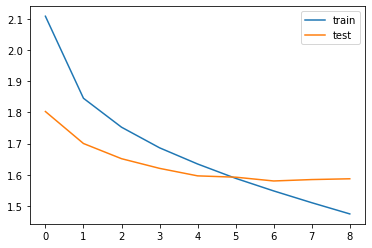

In [14]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

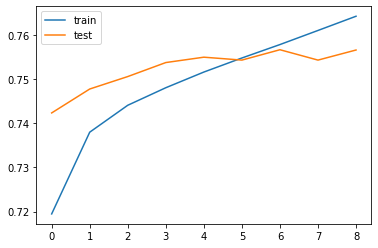

In [15]:
from matplotlib import pyplot
pyplot.plot(history.history['sparse_categorical_accuracy'], label='train')
pyplot.plot(history.history['val_sparse_categorical_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Inference setup

In [35]:
reverse_target_word_index= summary_tokenizer.index_word
reverse_source_word_index= article_tokenizer.index_word
target_word_index=summary_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = keras.Model(inputs=encoder_input,outputs=[encode2_output, state_h2, state_c2])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_input =  Input(shape=( None,))
decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(max_text_len,512))
decode_input_states = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
decoder_embedded1 = decoder_embedding_layer(decoder_input)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs, state_h3, state_c3 = decoder_LSTM(decoder_embedded1, initial_state=decode_input_states)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs = decoder_dense(decoder_outputs) 

# Final decoder model
decoder_model = keras.Model(
    [decoder_input] + [decoder_hidden_state_input]+ [decode_input_states],
    [decoder_outputs] + [state_h3, state_c3])


def conversion_to_wordsummary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def conversion_to_articletext(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

def decode_sequence(input_seq):
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']
    decoded_sentence = ''
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out,e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

for i in range(0,10):
    print("Review:",conversion_to_articletext(reviews_tr[i]))
    print("Original summary:",conversion_to_wordsummary(summary_tr[i]))
    print("Predicted summary:",decode_sequence(reviews_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: introduced product neice christmas flavorful refreshing love especially flu cold season 
Original summary: awesome product 
Predicted summary:  refreshing


Review: great price excellent chip cent ounce bag bargain well tasty chip everyone let try impressed commented good taste yet find kettle chip disappointed 
Original summary: tasty 
Predicted summary:  great chip


Review: never used product researched purchased red mill item home grocery stor like trust product different pleased folk sent fast packed well thank 
Original summary: hoping 
Predicted summary:  great product


Review: remembered childhood available store sure wish would bring back locally 
Original summary: delicious 
Predicted summary:  great


Review: love ship alaska hard time finding plant tree would actually ship bush alaska would totally recommend teacher living want little tree home lot bush alaska tundraso tree 
Original summary: ship alaska 
Predicted summary:  plant


Review: ordered hot cocoa grands

Inference from Loaded model

In [13]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout,Input,Activation,Bidirectional,TimeDistributed
reverse_target_word_index= summary_tokenizer.index_word
reverse_source_word_index= article_tokenizer.index_word
target_word_index=summary_tokenizer.word_index


loaded_model  = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/saved_models/biLSTM_reviews_model")
en_outputs,forward_state_h_enc,forward_state_c_enc,backward_state_h_enc,backward_state_c_enc = loaded_model.layers[4].output
concatenate = loaded_model.layers[6]
encoder_h = concatenate([forward_state_h_enc,backward_state_h_enc])
concatenate_1 = loaded_model.layers[7]
encoder_c = concatenate_1([forward_state_c_enc,backward_state_c_enc])
en_states=[forward_state_h_enc,forward_state_c_enc,backward_state_h_enc,backward_state_c_enc]
# Encode the input sequence to get the feature vector
encoder_model = keras.Model(inputs=loaded_model.input[0],outputs=[en_outputs, encoder_h ,encoder_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_input =  Input(shape=( None,))
decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(max_text_len,512))
decode_input_states = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_inputs = loaded_model.input[1]
dec_emb_layer = loaded_model.layers[5]
dec_lstm = loaded_model.layers[8]
dec_embedding= dec_emb_layer(dec_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs, state_h3, state_c3 = dec_lstm(dec_embedding, initial_state=decode_input_states)

# A dense softmax layer to generate prob dist. over the target vocabulary
dec_dense = loaded_model.layers[9]
decoder_outputs = dec_dense(decoder_outputs)

# Final decoder model
decoder_model = keras.Model(
    [dec_inputs] + [decoder_hidden_state_input]+ [decode_input_states],
    [decoder_outputs] + [state_h3, state_c3])


def conversion_to_wordsummary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def conversion_to_articletext(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

def decode_sequence(input_seq):
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']
    decoded_sentence = ''
    e_out, en_h,en_c = encoder_model.predict(input_seq)
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, en_h,en_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

for i in range(0,10):
    print("Review:",conversion_to_articletext(reviews_tr[i]))
    print("Original summary:",conversion_to_wordsummary(summary_tr[i]))
    print("Predicted summary:",decode_sequence(reviews_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: introduced product neice christmas flavorful refreshing love especially flu cold season 
Original summary: awesome product 
Predicted summary:  refreshing refreshing refreshing refreshing refreshing refreshing refreshing refreshing refreshing


Review: great price excellent chip cent ounce bag bargain well tasty chip everyone let try impressed commented good taste yet find kettle chip disappointed 
Original summary: tasty 
Predicted summary:  great chip good chip good chip good chip good


Review: never used product researched purchased red mill item home grocery stor like trust product different pleased folk sent fast packed well thank 
Original summary: hoping 
Predicted summary:  great product exactly great product exactly great product exactly


Review: remembered childhood available store sure wish would bring back locally 
Original summary: delicious 
Predicted summary:  great gift loved


Review: love ship alaska hard time finding plant tree would actually ship bush alas